In [ ]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.nn import CrossEntropyLoss
from collections import Counter
from transformers import EarlyStoppingCallback
import os

# load immigration labels
df = pd.read_csv("final_immigration_labels.csv")
df = df.dropna(subset=["Text_Preprocessed", "ImmigrationRelated"])
df["immigration_label"] = df["ImmigrationRelated"].astype(int)

# split data
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["immigration_label"])
train_df, val_df = train_test_split(train_val_df, test_size=0.1, random_state=42, stratify=train_val_df["immigration_label"])
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# tokenize
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# generate classes
class SimpleBinaryDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.encodings = tokenizer(df["Text_Preprocessed"].tolist(), truncation=True, padding="max_length", max_length=max_length)
        self.labels = torch.tensor(df["immigration_label"].tolist(), dtype=torch.long)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SimpleBinaryDataset(train_df, tokenizer)
val_dataset = SimpleBinaryDataset(val_df, tokenizer)
test_dataset = SimpleBinaryDataset(test_df, tokenizer)

# class weight skews
label_counts = Counter(train_df["immigration_label"])
total = sum(label_counts.values())
class_weights = [1.0, 5.0]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=2)
model.classifier.weight.data = model.classifier.weight.data.clone()

# custom trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.tensor(logits).argmax(dim=-1).numpy()
    labels = torch.tensor(labels).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# training arguments
training_args = TrainingArguments(
    report_to="wandb",
    output_dir="./immigration_classifier_2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1,
    gradient_checkpointing=False,
    max_grad_norm=1.0
)

# training
trainer = WeightedLossTrainer(
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

trainer.train()

# fine-tuning
finetune_args = TrainingArguments(
    output_dir="./immigration_classifier_2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=5e-6,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0
)

finetune_trainer = WeightedLossTrainer(
    model=model,
    args=finetune_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

finetune_trainer.train()

# evaluate, custom threshold
logits, labels = finetune_trainer.predict(test_dataset)[:2]
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
labels = torch.tensor(labels).numpy()
custom_threshold = 0.3
custom_preds = (probs[:, 1] >= custom_threshold).astype(int)

print(f"\nClassification Report (threshold={custom_threshold}):")
print(classification_report(labels, custom_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(labels, custom_preds))

# save model
save_path = "immigration_classifier_2_final_model"
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model and tokenizer saved to {save_path}")

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in ve

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.090300,0.137064,0.914163,0.921053,0.972222,0.945946
2,0.087600,0.111003,0.916309,0.912596,0.986111,0.947931
3,0.099300,0.155263,0.927039,0.955307,0.950000,0.952646
4,0.040900,0.194030,0.929185,0.945504,0.963889,0.954608
5,0.134400,0.198191,0.933476,0.948229,0.966667,0.957359


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-35cdb30d11db>:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  finetune_trainer = WeightedLossTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000800,0.222256,0.933476,0.943396,0.972222,0.957592
2,0.067800,0.255392,0.929185,0.943089,0.966667,0.954733



Classification Report (threshold=0.3):
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       264
           1       0.93      0.96      0.95       900

    accuracy                           0.91      1164
   macro avg       0.89      0.86      0.87      1164
weighted avg       0.91      0.91      0.91      1164


Confusion Matrix:
[[199  65]
 [ 34 866]]
Model and tokenizer saved to immigration_classifier_2_final_model


<ipython-input-3-a7219b26c5a4>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
<ipython-input-3-a7219b26c5a4>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_post_counts = df.groupby(['City', 'Time_Period', 'Username']).size().reset_index(name='Comment_Count')


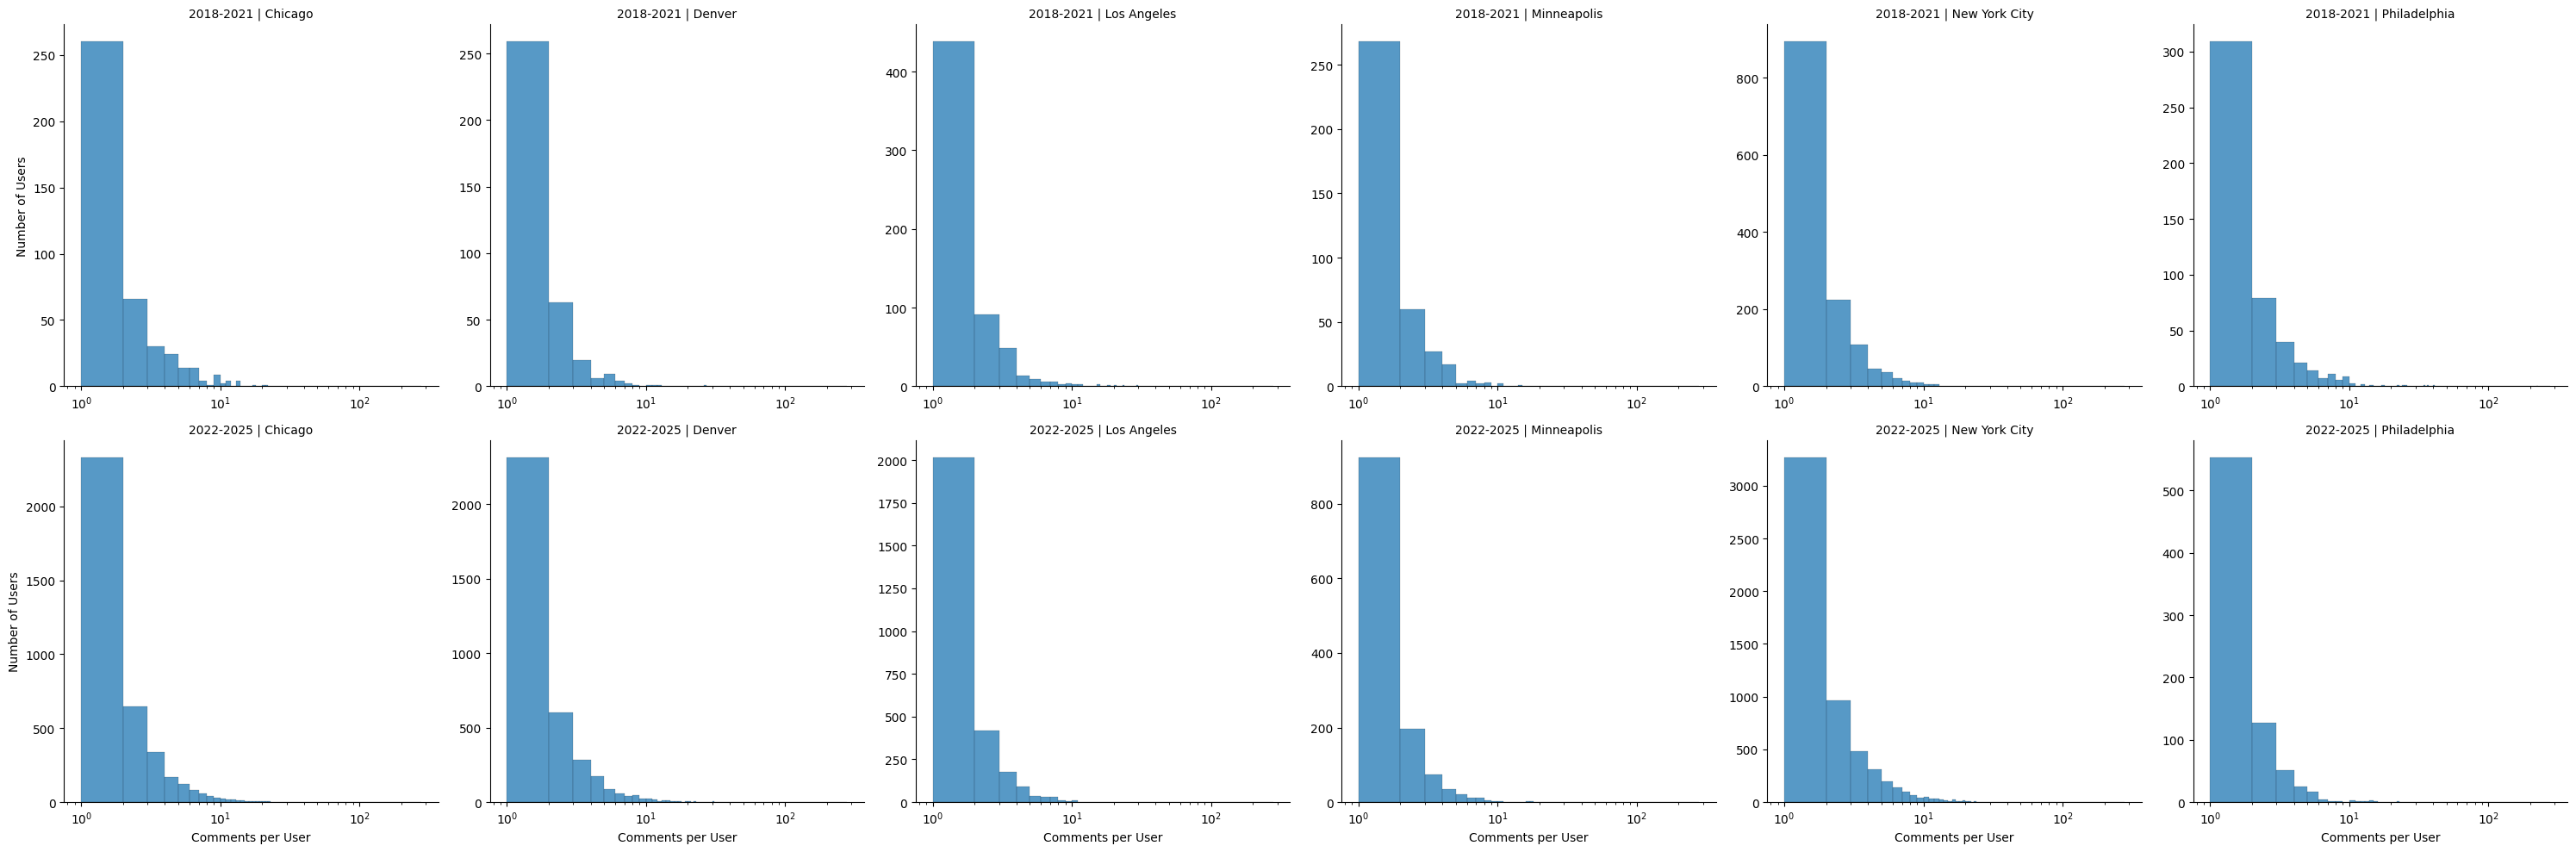

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("all_immigration_comments_sentiment_labels.csv")

# Ensure date is in datetime format and year is extracted
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

# Define time periods
df['Time_Period'] = pd.cut(df['Year'], bins=[2017, 2021, 2025], labels=['2018-2021', '2022-2025'])

# Filter valid usernames and immigration-related comments
df = df[
    (df['ImmigrationRelated'] == 1) &
    (~df['Username'].isin(['[deleted]', '[Removed]'])) &
    (df['Username'].notna())
]

# Group to get the number of comments per user per stratum
user_post_counts = df.groupby(['City', 'Time_Period', 'Username']).size().reset_index(name='Comment_Count')

# Filter users with at least one comment
user_post_counts = user_post_counts[user_post_counts['Comment_Count'] > 0]

# Plot distributions using seaborn
g = sns.displot(
    data=user_post_counts,
    x="Comment_Count",
    col="City",
    row="Time_Period",
    binwidth=1,
    facet_kws={'sharex': False, 'sharey': False}
)

# Format plot
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("Comments per User", "Number of Users")
g.set(xscale="log")
plt.tight_layout()
plt.show()